In [22]:
using JuMP, Ipopt, Plots

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3987
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4776

Total number of variables............................:     1001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:      803
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

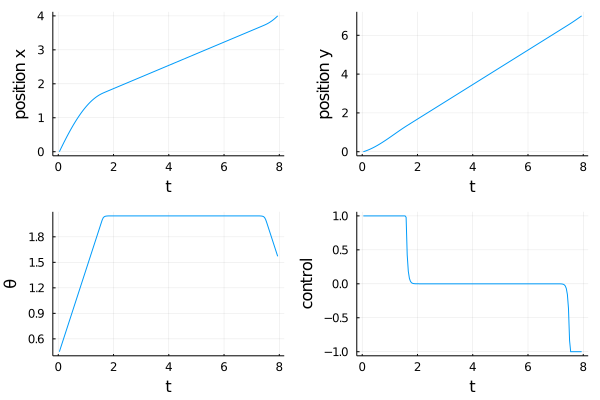

1.0000000000000003e-5

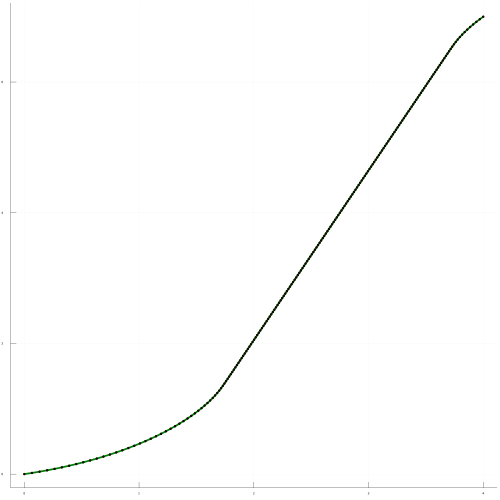

In [14]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.6
epsi = 10^(-5)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
c0 =0

# final data
xf = 4
yf = 7
θf = pi/2 

N = 200
# Bounds for variables

JuMP.@variables(sys,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1 
        c[1:N]
    end)

# Objective
@objective(sys,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    c[1]==c0
    x[N] == xf
    y[N] == yf
    θ[N] == θf
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end

@NLconstraint(sys,p_t[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
u1 = value.(u)
println("Cost : " , objective_value(sys))

println("tf = ", value.(Δt)*N)

#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,u_plot, layout = (2,2)))

#plots : trajectory 

p = plot(x1,y1, c = :green, lw = 7)
plot!(size=(2000,2000))

for i = 1 : N 
    z = [x1[i] y1[i]]
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:red , legend = false, lw = 10) 
    plot!(size=(2000,2000))
end
current()

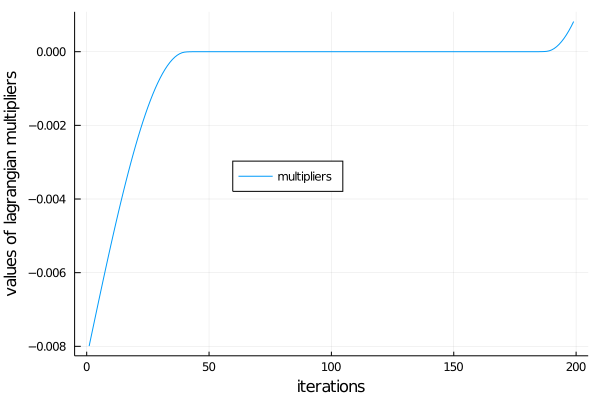

has_dual ? : true


In [16]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))

Solving...


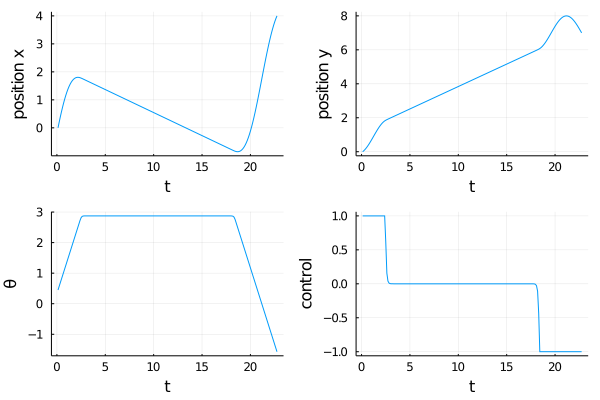

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3987
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4776

Total number of variables............................:     1001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:      803
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

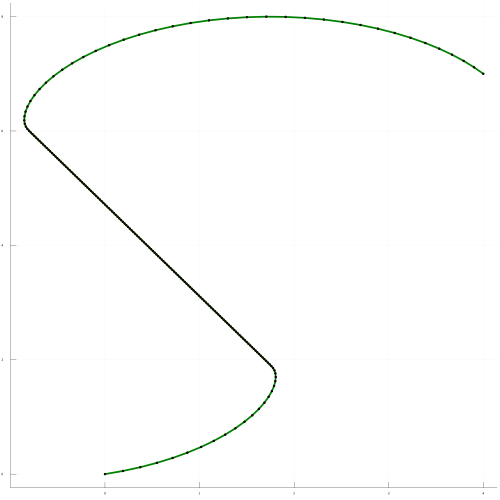

In [18]:
#JuMP model, Ipopt solver
sys2 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys2,"tol",1e-14)
set_optimizer_attribute(sys2,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.6
epsi = 10^(-4)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
c0 = 0

# final data
xf = 4
yf = 7
θf = -pi/2 

N = 200
# Bounds for variables

JuMP.@variables(sys2,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1 
    c[1:N]
    end)

# Objective
@objective(sys2,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys2,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    c[1] == c0
    x[N] == xf
    y[N] == yf
    θ[N] == θf
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys2, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys2, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys2, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))   
end

@NLconstraint(sys2,p_t2[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

#Solve for the control and state
println("Solving...")
status = optimize!(sys2)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
u1 = value.(u)
println("Cost : " , objective_value(sys2))

println("tf = ", value.(Δt)*N)

#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1
#h = (1 : N)

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,u_plot, layout = (2,2)))

#plots : trajectory 

p = plot(x1,y1, c = :green, lw = 7)
plot!(size=(2000,2000))

for i = 1 : N 
    z = [x1[i] y1[i]]
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:red , legend = false, lw = 10) 
    plot!(size=(2000,2000))
end
current()

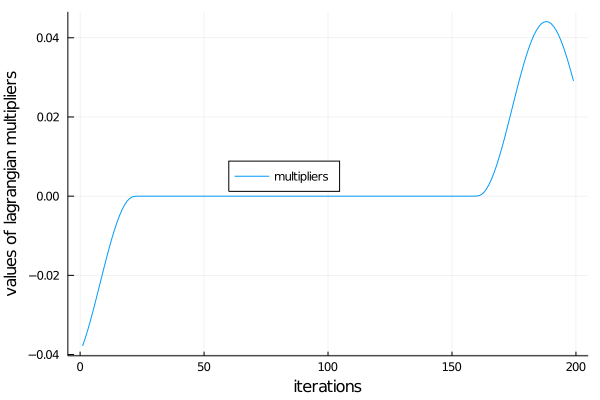

has_dual ? : true


In [19]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys2))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t2[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))

Solving...


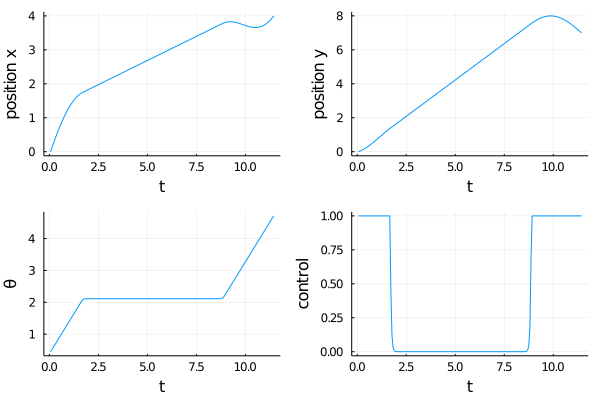

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3987
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4776

Total number of variables............................:     1001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:      803
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

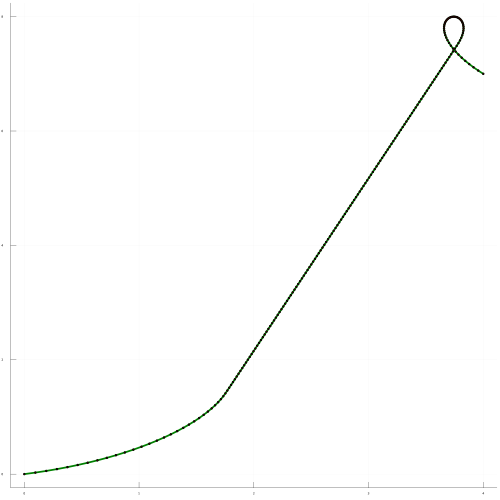

In [20]:
#JuMP model, Ipopt solver
sys3 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys3,"tol",1e-14)
set_optimizer_attribute(sys3,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.6
epsi = 10^(-5)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
c0 = 0


# final data
xf = 4
yf = 7
θf = 3*pi/2 

N = 200
# Bounds for variables

JuMP.@variables(sys3,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1  
    c[1:N]
    end)

# Objective
@objective(sys3,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys3,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    c[1]==c0
    x[N] == xf
    y[N] == yf
    θ[N] == θf
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys3, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys3, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys3, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end
    @NLconstraint(sys3,p_t3[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )



#Solve for the control and state
println("Solving...")
status = optimize!(sys3)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
u1 = value.(u)
println("Cost : " , objective_value(sys3))

println("tf = ", value.(Δt)*N)

#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1
#h = (1 : N)

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,u_plot, layout = (2,2)))

#plots : trajectory 

p = plot(x1,y1, c = :green, lw = 7)
plot!(size=(2000,2000))

for i = 1 : N 
    z = [x1[i] y1[i]]
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:red , legend = false, lw = 10) 
    plot!(size=(2000,2000))
end
current()

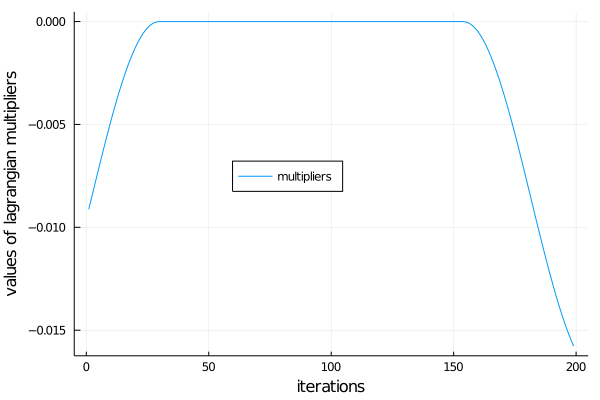

has_dual ? : true


In [21]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys3))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t3[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))